<h2 style='color:blue' align='center'>FAMILY Image Classification: Data Cleaning<h2>

In [2]:
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

#### When we look at any image, most of the time we identify a person using a face. An image might contain multiple faces, also the face can be obstructed and not clear. The first step in our pre-processing pipeline is to detect faces from an image. Once face is detected, we will detect eyes, if two eyes are detected then only we keep that image otherwise discard it.</h4>

#### Now how do you detect face and eyes?

In [3]:
img = cv2.imread('./TEST/TEST1.jpg')
img.shape

(4000, 3000, 3)

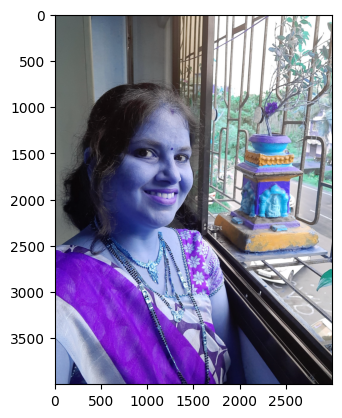

In [4]:
plt.imshow(img)

In [5]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray.shape

(4000, 3000)

In [6]:
gray

array([[100, 100, 100, ..., 255, 233, 181],
       [100, 100, 100, ..., 255, 233, 180],
       [100, 100, 100, ..., 255, 232, 178],
       ...,
       [168, 168, 168, ...,  14,  14,  14],
       [168, 168, 168, ...,  14,  14,  14],
       [168, 168, 168, ...,  14,  14,  14]], dtype=uint8)

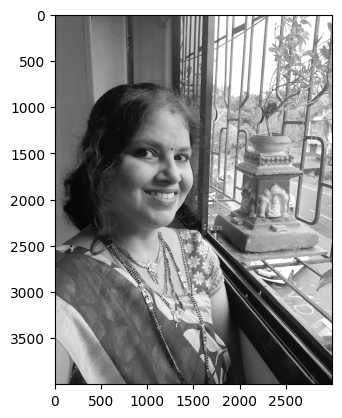

In [7]:
plt.imshow(gray, cmap='gray')

In [8]:
face_cascade = cv2.CascadeClassifier('./opencv/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./opencv/haarcascade_eye.xml')

faces = face_cascade.detectMultiScale(gray, 1.3, 5)
faces

array([[ 705, 1140,  989,  989]])

In [9]:
(x,y,w,h) = faces[0]
x,y,w,h

(705, 1140, 989, 989)

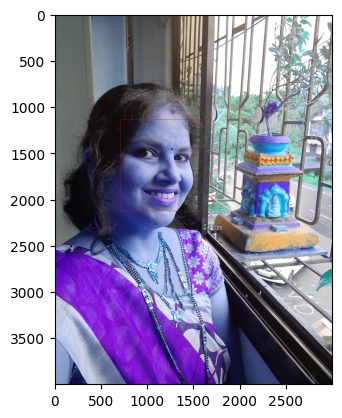

In [10]:
face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
plt.imshow(face_img)

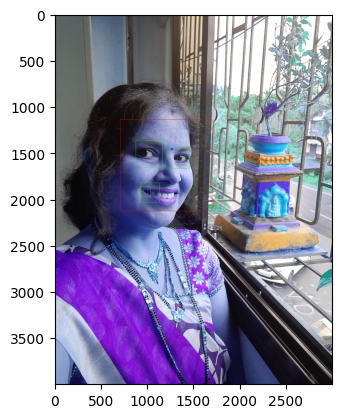

In [11]:
cv2.destroyAllWindows()
for (x,y,w,h) in faces:
    face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = face_img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
        

plt.figure()
plt.imshow(face_img, cmap='gray')
plt.show()

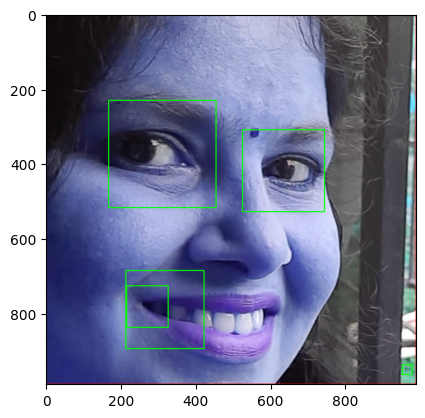

In [12]:
%matplotlib inline
plt.imshow(roi_color, cmap='gray')

In [13]:
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color

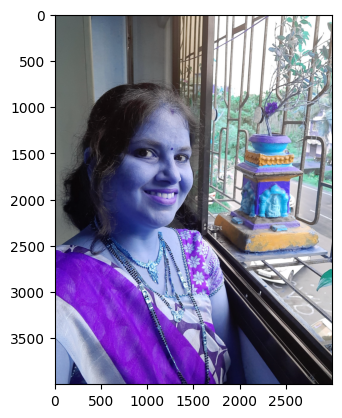

In [14]:
original_image = cv2.imread('./TEST/TEST1.jpg')
plt.imshow(original_image)

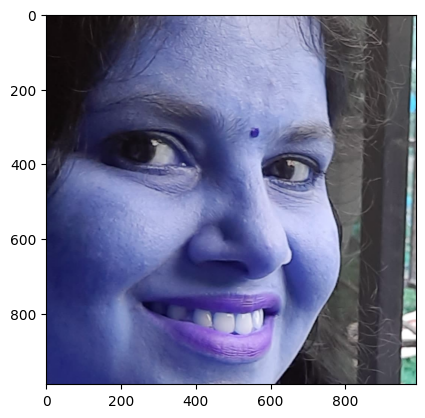

In [15]:
cropped_image = get_cropped_image_if_2_eyes('./TEST/TEST1.jpg')
plt.imshow(cropped_image)

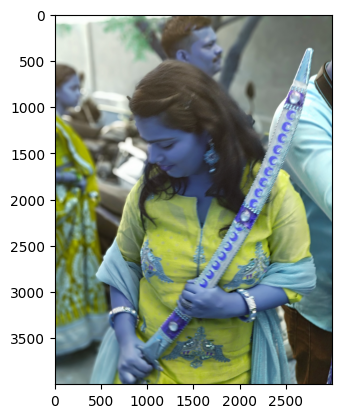

In [16]:
org_image_obstructed = cv2.imread('./TEST/TEST2.jpg')
plt.imshow(org_image_obstructed)

In [17]:
cropped_image_no_2_eyes = get_cropped_image_if_2_eyes('./TEST/TEST2.jpg')
cropped_image_no_2_eyes

In [18]:
path_to_data = "./dataset/"
path_to_cr_data = "./dataset/cropped/"

In [19]:
import os
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [20]:
img_dirs

['./dataset/cropped',
 './dataset/rekha',
 './dataset/roshani',
 './dataset/shubham']

In [21]:
import shutil
if os.path.exists(path_to_cr_data):
     shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

In [22]:
cropped_image_dirs = []
member_file_name_dict = {}

for img_dir in img_dirs:
    count = 1
    member_name = img_dir.split('/')[-1]
    print(member_name)
    
    member_file_name_dict[member_name] = []
    
    for entry in os.scandir(img_dir):
        roi_color = get_cropped_image_if_2_eyes(entry.path)
        if roi_color is not None:
            cropped_folder = path_to_cr_data + member_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped images in folder: ",cropped_folder)
                
            cropped_file_name = member_name + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name 
            
            cv2.imwrite(cropped_file_path, roi_color)
            member_file_name_dict[member_name].append(cropped_file_path)
            count += 1    

cropped
rekha
Generating cropped images in folder:  ./dataset/cropped/rekha


roshani
Generating cropped images in folder:  ./dataset/cropped/roshani
shubham
Generating cropped images in folder:  ./dataset/cropped/shubham


In [23]:
#(3) Preprocessing: Use wavelet transform as a feature for traning our model
#In wavelet transformed image, you can see edges clearly and that can give us clues
# on various facial features such as eyes, nose, lips etc
#Wavelet transform

In [24]:
import numpy as np
import pywt
import cv2    

def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

In [25]:
class_dict = {}
count = 0
for member_name in member_file_name_dict.keys():
    class_dict[member_name] = count
    count = count + 1
class_dict

{'cropped': 0, 'rekha': 1, 'roshani': 2, 'shubham': 3}

In [26]:
X, y = [], []
for member_name, training_files in member_file_name_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        if img is None : 
            continue
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[member_name]) 

In [27]:
len(X[0])
32*32*3 + 32*32
X[0]
y[0]
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(82, 4096)

In [28]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report


In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.6190476190476191

In [30]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [31]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [32]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.703846,"{'svc__C': 10, 'svc__kernel': 'rbf'}"
1,random_forest,0.703846,{'randomforestclassifier__n_estimators': 5}
2,logistic_regression,0.656410,{'logisticregression__C': 1}


In [33]:
best_estimators['svm'].score(X_test,y_test)

0.6190476190476191

In [34]:
best_estimators['random_forest'].score(X_test,y_test)

0.7142857142857143

In [35]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.7619047619047619

In [36]:
best_clf = best_estimators['logistic_regression']

Text(95.72222222222221, 0.5, 'Truth')

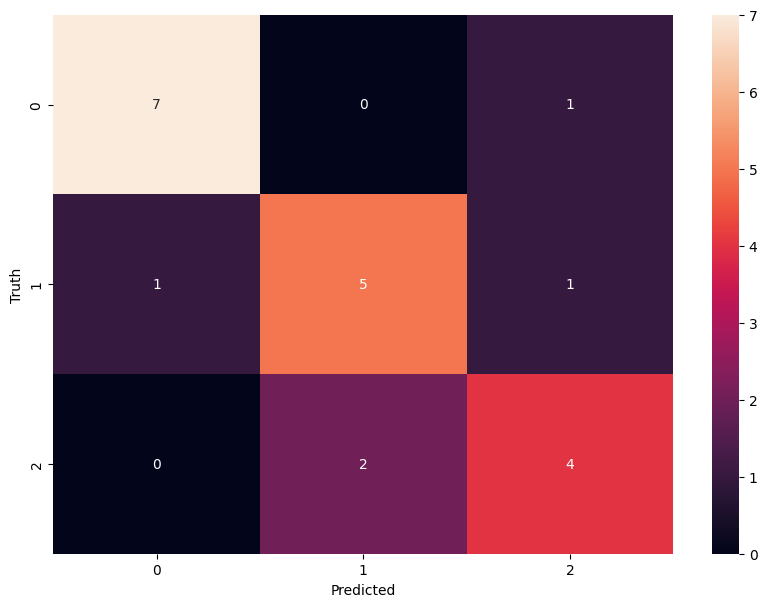

In [37]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')


In [38]:
class_dict

{'cropped': 0, 'rekha': 1, 'roshani': 2, 'shubham': 3}

In [39]:
%pip install joblib
import joblib 
# Save the model as a pickle in a file 
joblib.dump(best_clf, 'saved_model.pkl')

['saved_model.pkl']

In [40]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))